# Robert Martino 
# Data Analytics Hw 7
### 11/30/2018

#### A quick note on formatting/language etc.:
So I decided to use python in a jupyter notebook because I'd like to say that I felt that the best way to truly understand the material is to implement it in a language where I can't just copypasta from the lectures and the labs. But more honestly it is that the place I am going to be starting in a month as a data scientist is a 100% python shop, and though I have a long history with and used python in Machine Learning from data with Malik, Data Mining with Zaki, Deep Learning with Xi, my previous internships, etc.  I figured that this would be a great refresher on the job skills expected of me on day 1, where the principles acquired in this class will be on full display (thank you for that, I learned a lot about preprocessing/analysis and some more interesting models I had not come across before, and details of models I hadn't fully appreciated). While I do like R and had a good experience with it this semester, and also in Data Mathematics with Piper, I really struggled to resist the temptation and eventually conceeded to my pythonic urges. I apologize.

## Saluting the Red, White, and Booze: What will it be tonight?

### Ultimately my goal here is to be able to use the features available to classify between red and white, and use insight from that to determine what wine to choose based on what you are in the mood for

#### So my first matter of business was parsing the two datasets, labeling them (0 for red, 1 for wine) under the label "color" and concatenating them into DataFrame df

#### Here we see also we have more (close to 3x) white samples than red samples. We will have to keep that in mind for plotting and vetting metrics for performance (precision/recall vs accuracy)

In [42]:
import pandas as pd
import numpy as np
import random
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline

f = open("winequality-white.csv")
lines = f.readlines()
header = filter(lambda x: x != '' and x !=';', lines[0].rstrip().split('\"'))
dfwhite = pd.DataFrame([np.float32(np.array(l.rstrip().split(";"))) for l in lines[1:]],columns = header)
f.close()

f = open("winequality-red.csv")
lines = f.readlines()
header = filter(lambda x: x!='' and x!=';', lines[0].rstrip().split('\"'))
dfred = pd.DataFrame([np.float32(np.array(l.rstrip().split(";"))) for l in lines[1:]],columns = header)
f.close()

dfwhite["color"] = 1
dfred["color"] = 0
df = pd.concat([dfwhite,dfred])
df.index = range(len(df))
labels = df["color"]
df = df[df.columns.drop("color")]
print "Number of Red samples: {}".format(len(labels)-sum(labels))
print "Number of White samples: {}".format(sum(labels))


Number of Red samples: 1599
Number of White samples: 4898


#### Next, I normalized the dataset around its mean

In [34]:
df_norm = (df - df.mean()) / (df.max() - df.min())

#### Then I created df_z, a dataframe containing each columns respective z score. Because I normalized between -1 and 1 I feel more confident in Gaussian behavior and the suitability of Z score to determine outlier status.

#### Ultimately I will not be doing analysis on df_z, but rather using it for outlier detection. I set threshold to be standard deviations from the mean that I am willing to tolerate for any feature of any datum

#### This number was picked to keep percentage of outliers lower than 5%, which I saw as reasonable

In [38]:
df_z = pd.DataFrame()
cols = header
for col in cols:
    col_zscore = col + '_zscore'
    df_z[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    
threshold = 3.5

print "Number of data points: {}".format(len(df_z))

odf_z = df_z[(df_z.max(axis=1)<threshold)]
odf_z = odf_z[(odf_z.min(axis=1)>-1*threshold)]

print "Number of outliers: {}".format(len(df_z)-len(odf_z))
print "Percentage of outliers: {}".format(1-float(len(odf_z))/len(df_z))

df_noout = df.loc[odf_z.index]
df_norm = df_norm.loc[odf_z.index]
df_norm["color"] = labels.loc[odf_z.index]

Number of data points: 6497
Number of outliers: 287
Percentage of outliers: 0.044174234262


####  I now want to be able to visualize where the two types of wines are similar, and what are different, and I think histogram here is the best tactic for doing this. I do realize that in the line under "HIST CALL" I have to put "normed=TRUE", which makes it seem like there is as many reds as whites, which is helpful for our purposes

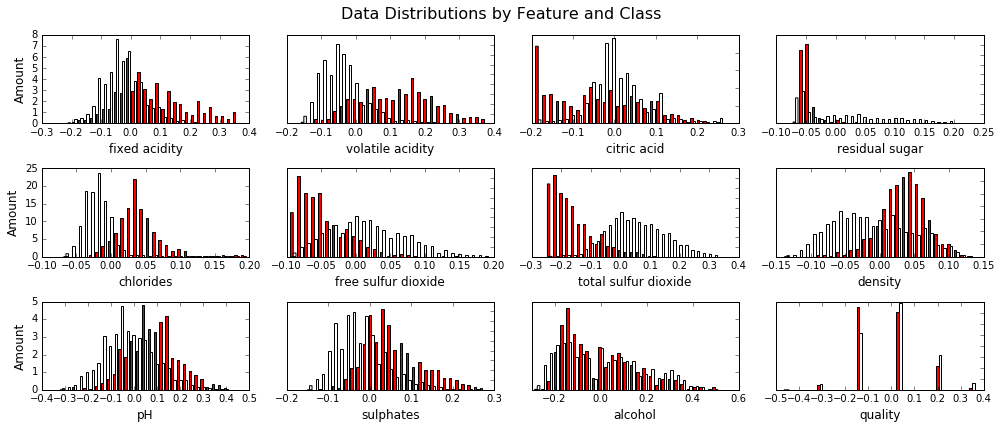

In [4]:
data_cols = header
data = df_norm

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots(figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)))
    
    red = data.loc[data.color == 0,col]
    white = data.loc[data.color == 1, col]
    b = np.linspace(np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30)
    
    #HIST CALL
    axarr[i].hist([red,white], label=['red','white'],bins=b,normed=True,color=["red","white"] )
    
    
    axarr[i].set_xlabel(col, size=12)
    axarr[i].tick_params(axis='both', labelsize=10)
    
    if i%columns != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Amount',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()

#### We see this analysis is very successful. Total sulfur dioxide, chlorides, density, and free sulfur dioxide have distinct means and variances, whereas alcohol, quality etc. don't seem to make a distinction. 

### The first model I want to try is a boosted decision tree model. This is definitely a model I have not had the pleasure of trying out before but I find the concept really cool and if for anything else except experience sake I want to give it a whirl.

#### I'll be using the xgboost package, standard fare

In [43]:
import xgboost as xgb

#### I'll also be using metrics for performance from sklearn. As alluded to with uneven number of samples, and train/test split for obvious reasons

In [45]:
from sklearn.metrics import recall_score, precision_score,roc_auc_score,confusion_matrix,accuracy_score 
from sklearn.cross_validation import train_test_split  

#### Give it a good 80/20 split as is tradition. Random seed set at 100 because that's how I like to keep it

In [94]:
X = df_norm.drop('color', axis=1)  
y = df_norm['color']  
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state=100)

#### Define some custom metric functions for use with the xgboost algorithm
###### https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

In [8]:
def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [9]:
print "Number Train:",len(y_train)
print "Number Test:",len(y_test)
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test, y_test, feature_names=X_train.columns)

Number Train: 4968
Number Test: 1242


#### My objective here is to maximize recall on the test set. That way precision will follow, and therefore accuracy. I'm setting early stopping to 100, as I don't think that'll come into play at a dataset this small, given my number of boost rounds being set conservatively at 20. While I want to avoid overfitting the boosting should help with that.

In [ ]:
xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 100,
    'eval_metric': 'auc', 
}

results_dict = {}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=20, 
                     verbose_eval=False,
                     early_stopping_rounds=100, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
                    )

#### We now have the results. Wow. We killed it. 20 was a good number of iterations. I thought it was a little low but boy did it find a maximum fast. I immediately get a whiff of overfitting, because those values (accuracy, recall, area under curve) are shockingly high. But with it being a powerful model with very distinct, chemical (read: real world) features, this may be simply a solid model that is correctly distinguishing between red and white wine, a task which is obvious to anyone who is sighted or has the sense of taste.

best iteration:  6
('recall', 1.0)
('precision', 0.99275362318840576)
('roc_auc', 0.98763250883392228)
('Accuracy', 0.99436392914653782)
       Red  White
Red    276      7
White    0    959


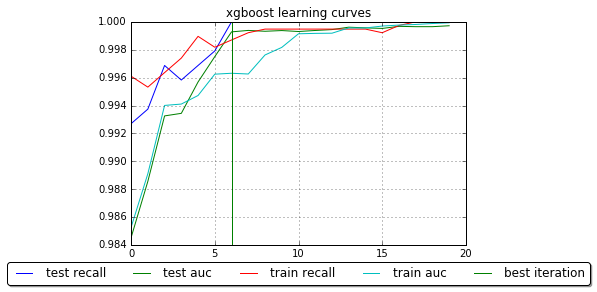

In [11]:
y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_pred = np.round(y_pred,decimals=0,out=None)
y_true = y_test.values

print 'best iteration: ', xgb_test.best_iteration 
print recall( y_pred, dtest ) 
print precision( y_pred, dtest ) 
print roc_auc( y_pred, dtest ) 


print ("Accuracy",accuracy_score(y_true, y_pred))
print pd.DataFrame(confusion_matrix(y_true, y_pred),index=["Red","White"],columns=["Red","White"])

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
        
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')

plt.xlabel('iteration')
plt.title('xgboost learning curves')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.grid() ;

#### the confusion matrix is interesting as well. We see that the misclassifications that occured were reds mistaken as white. This could be an artifact of the particular random seed, or it would be because we have ourselves a white majority.

#### Now let us look at importance of features. We aren't looking for which way they predict (that will be for our next model) but simply how important they are for distinguishing between the two. 

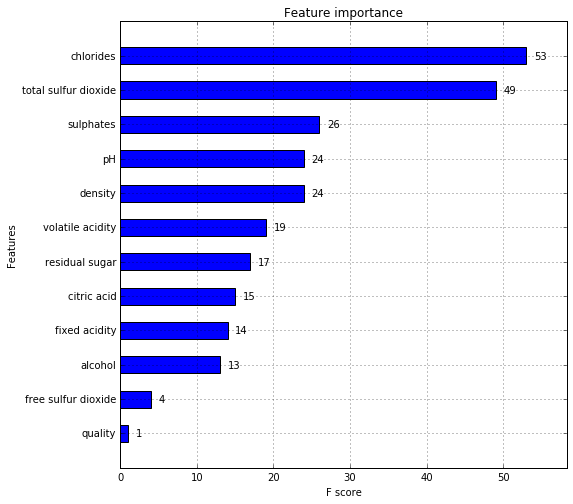

In [12]:
# Plot feature importances
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=15, height=0.5, ax=ax);

### The next model looked at was an svm. This is a good model when there exists an uneven number of samples per class because the only things that matter to its out of sample error are number of support vectors

In [91]:
from sklearn import svm
from mlxtend.plotting import plot_decision_regions

#### I used the linear kernel on this svm, as it has the fewest degrees of freedom comparatively and given xgboost's quick convergence I don't think a more complex model would help much. I chose C=2 and degree=4, tolerance=0.01, with similar reasoning. Accuracy was almost identical to xgboost. Moving on...

In [95]:
clf = svm.SVC(kernel='linear',C=2,degree=4,tol=0.01)
clf.fit(X_train, y_train)
clf_predictions = clf.predict(X_test)
print("Accuracy: {}%".format(clf.score(X_test, y_test) * 100 ))

Accuracy: 99.114331723%


#### PLotting cholorides (from the insight of the above chart) vs all other features (to keep it 2-D) Here we see some of the synergy between other important features, such as total sulfur dioxide.

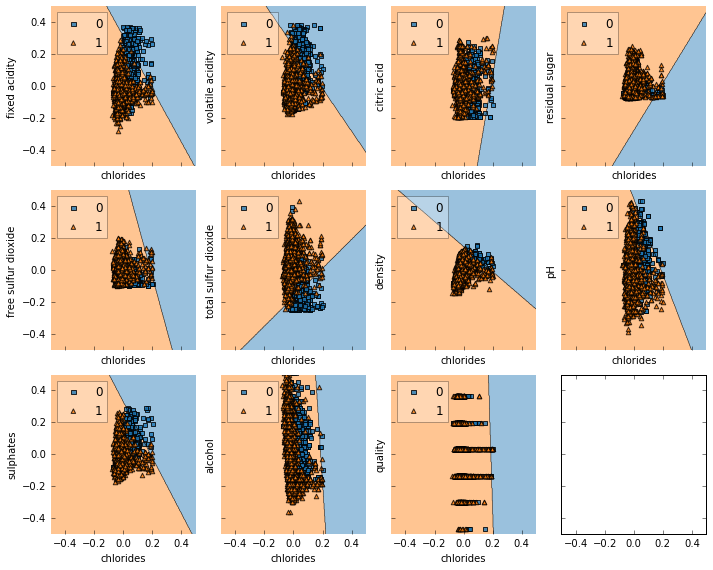

In [96]:
fig, axarr = plt.subplots(3, 4, figsize=(10,8), sharex=True, sharey=True)
values = [0, 0, 0, 0]
width = 1
value = 0

cols = X_train.columns
feat1 = cols.get_loc("chlorides")

no_feat1 = range(0,12)
no_feat1.pop(feat1)

for feat2,ax in zip(no_feat1,axarr.flat):
    r = range(0,12)
    r.pop(feat1)
    if feat2 < feat1:
        r.pop(feat2)
    else:
        r.pop(feat2-1)
    plot_decision_regions(X_train.values, y_train.values, clf=clf,
                          filler_feature_values={x: value for x in r},
                          filler_feature_ranges={x: width for x in r},
                          feature_index=[feat1,feat2],
                          legend=2, ax=ax)
    ax.set_xlabel(X_train.columns[feat1])
    ax.set_ylabel(X_train.columns[feat2])
    ax.set_ylim(bottom=-0.5,top=0.5)
    ax.set_xlim(left=-0.5,right=0.5)

plt.tight_layout()
plt.show()

#### We also get to see here things like quality and alcohol not really mattering, as xgboost told us.

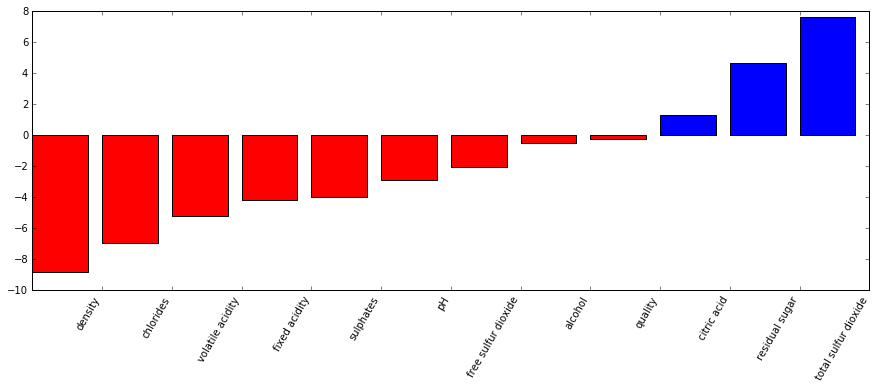

In [97]:
# https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=6):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
plot_coefficients(clf, X_train.columns)

#### The benefit of the svm is that it gives directional importance based on its features. Here we see insights into making prescriptions as well as predictions.

#### Ultimately it comes down to what are you in the mood for. It is easy to take a series of features and predict whether you'd fancy a red or a white, the xgboost and svm could both do that very easily. The decision based on a single feature is now more easily determined by the above chart. Do you want something sweet, slightly acidic, airy wine?  Try a white. Would you like an acidic, dense tart wine? How about a red, perhaps merlot?

## Who should we annoy at dinner today? Determining who will fall for bank sales pitches over the phone

#### Here we have the bank sales dataset. First we parse out the data into dfbank. Then break it out into categorical vs numeric. This is important as this feature distinction will be the one we're using to predict and analyze the data

In [99]:
f = open("bank.csv")
lines = f.readlines()
header = filter(lambda x: x != '' and x !=';', lines[0].rstrip().split('\"'))
dfbank = pd.DataFrame([np.array(l.rstrip().split(";")) for l in lines[1:]],columns=header)
f.close()


dfbank['default'] = dfbank['default'].map({'"yes"': 1.0, '"no"': 0.0})
dfbank['housing'] = dfbank['housing'].map({'"yes"': 1.0, '"no"': 0.0})
dfbank['loan'] = dfbank['loan'].map({'"yes"': 1.0, '"no"': 0.0})
dfbank['y'] = dfbank['y'].map({'"yes"': 1.0, '"no"': 0.0})


for col in ['job','marital','education','contact','month','poutcome']:
    dfbank[col] = dfbank[col].map({x:x.rstrip('"').lstrip('"') for x in dfbank[col].value_counts().index})

dfbank[['age','balance','duration','previous','y']] = dfbank[['age','balance','duration','previous','y']].astype(np.float32)

dfreg = dfbank[['age','balance','duration','previous','y']]
dfcat = dfbank[['job','marital','education','default','housing','loan','contact','poutcome','y']]
dfbank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30.0,unemployed,married,primary,0.0,1787.0,0.0,0.0,cellular,19,oct,79.0,1,-1,0.0,unknown,0.0
1,33.0,services,married,secondary,0.0,4789.0,1.0,1.0,cellular,11,may,220.0,1,339,4.0,failure,0.0
2,35.0,management,single,tertiary,0.0,1350.0,1.0,0.0,cellular,16,apr,185.0,1,330,1.0,failure,0.0
3,30.0,management,married,tertiary,0.0,1476.0,1.0,1.0,unknown,3,jun,199.0,4,-1,0.0,unknown,0.0
4,59.0,blue-collar,married,secondary,0.0,0.0,1.0,0.0,unknown,5,may,226.0,1,-1,0.0,unknown,0.0
5,35.0,management,single,tertiary,0.0,747.0,0.0,0.0,cellular,23,feb,141.0,2,176,3.0,failure,0.0
6,36.0,self-employed,married,tertiary,0.0,307.0,1.0,0.0,cellular,14,may,341.0,1,330,2.0,other,0.0
7,39.0,technician,married,secondary,0.0,147.0,1.0,0.0,cellular,6,may,151.0,2,-1,0.0,unknown,0.0
8,41.0,entrepreneur,married,tertiary,0.0,221.0,1.0,0.0,unknown,14,may,57.0,2,-1,0.0,unknown,0.0
9,43.0,services,married,primary,0.0,-88.0,1.0,1.0,cellular,17,apr,313.0,1,147,2.0,failure,0.0


#### Here we see the a HUGE asymetry between positive and negative classes. We will have to HEAVILY rely on recall (and to a lesser extent precision) if we want meaningful results from this analysis

In [18]:
print "Successes:",len(np.where(dfbank['y']==1)[0])
print "Total:", len(dfbank['y'])

Successes: 521
Total: 4521


#### Normalize, you know the drill. Due to the number of "Unknown" answers, and categorical features in general, and limited number of positive examples, I am forgoing outlier analysis, as it may hurt more than it would help

In [100]:
df = dfreg[dfreg.columns.drop('y')]
df_norm = (df - df.mean()) / (df.max() - df.min())
df_norm['y'] = dfreg['y']

#### My favorite technique for categorical analysis is stacked crosstab analysis. It helps really show the quantitative inequalities between classes. Because there are way more no's than yes', we normalize the index so we can see the difference in ratio.

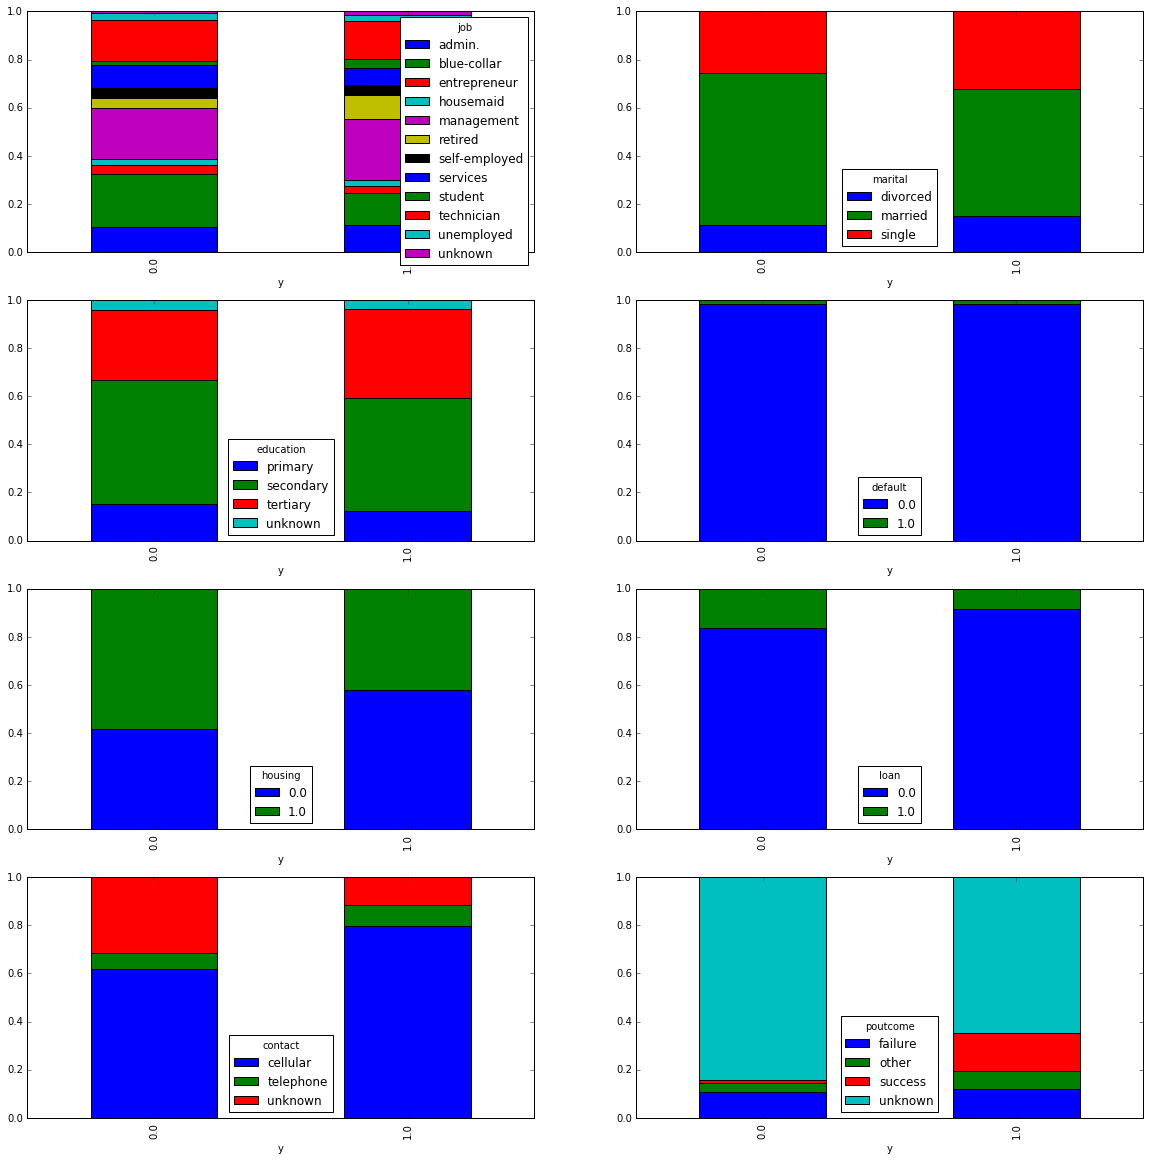

In [20]:
data_cols = dfcat.columns.drop('y')
data = dfcat[data_cols]

columns = 2
rows = int( np.ceil( len(data_cols) / columns ) )+1
f, axs = plt.subplots(ncols=3,figsize=(columns*10, rows*5) )

for i, col in enumerate(data_cols[:]):
    clarity_color_table = pd.crosstab(index=dfcat["y"],columns=dfcat[col],normalize='index')
    clarity_color_table.plot(kind="bar", ax=plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns))),stacked=True)

#### We learn quite a bit here. Things like default don't really mean anything. But if you're in college, or single, on a cell phone, or even own a house, can have a mildly significant effect on whether you will become a customer.  But the one really significant feature that we see is poutcome success. Which makes complete sense, if they have bitten before they are more likely to bite again.

#### Now below we are going to look at the numerical data using histograms, same code as above. Normalized again of course.

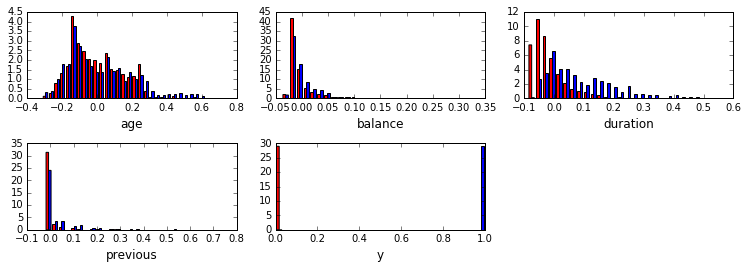

In [21]:
data_cols = df_norm.columns
data = df_norm

axarr = [[]]*len(data_cols)
columns = 3
rows = int( np.ceil( len(data_cols) / columns ) )+1
f, fig = plt.subplots(figsize=(columns*3.5, rows*2) )

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)))
    
    no = data.loc[data.y == 0,col]
    yes = data.loc[data.y == 1, col]
    b = np.linspace(np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30)
    
    
    axarr[i].hist([no,yes], label=['no','yes'],bins=b,normed=True,color=["red","blue"] )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].tick_params(axis='both', labelsize=10)
    
plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.show()

#### So nothing really interesting here, except duration, which seems to skew towards success. Which also makes sense, the longer they stay on the phone the more likely they are to accept.

### The first model(s) we will be using is a decision tree. 
#### We will be using it as strictly a classifier, then rounding a decision tree regressor. 
#### We will take the regression from the decision tree into the next model to create a hybrid model.

In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
onehot = pd.get_dummies(dfcat)
y = onehot.y
onehot = onehot[onehot.columns.drop('y')]
X_train, X_test, y_train, y_test = train_test_split(onehot, y, 
                                                    test_size=0.20,
                                                    random_state=100)

#### I used a gini criterion, with max depth of 6, and only 1 sample per leaf. These made sense given the data asymmetry and recommended heuristics

In [54]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=6, min_samples_leaf=1)
clf_gini.fit(X_train, y_train)
y_pred = clf_gini.predict(X_test)
print "Accuracy: ", accuracy_score(y_test,y_pred)*100
print "Recall: ", recall_score(y_test,y_pred)*100
print "Precsion: ", precision_score(y_test,y_pred)*100

Accuracy:  89.7237569061
Recall:  11.5789473684
Precsion:  55.0


#### Ok, so a few things of note, 1rst is that accuracy is pretty much a useless statistic. Just guessing 0 everytime would give you like 85% accuracy, so Recall, and precision are more important, specifically recall, because you really want to call as many possible customers as possible, given the cost/benefit of making a phone call. Recall at 11.5 is not good. Lets try to get that up shall we.

In [81]:
feat_dict = {x:y for x,y in zip(onehot.columns,clf_gini.feature_importances_) if y>0.03}
pd.DataFrame(np.matrix(feat_dict.values()),columns=feat_dict.keys())

,housing,job_retired,job_blue-collar,marital_married,contact_unknown,poutcome_success,loan
0,0.045008,0.066031,0.031166,0.064788,0.162722,0.425006,0.07551


#### so the categorical features with importance >0.03. Clearly poutcome_success is the biggest. CALL YOUR PREVIOUS SUCCESSES!

In [24]:
from sklearn.tree import DecisionTreeRegressor  
regressor = DecisionTreeRegressor()  
regressor.fit(X_train, y_train)  
y_pred = abs(np.round(regressor.predict(X_test)))
print "Accuracy: ", accuracy_score(y_test,y_pred)*100
print "Recall: ", recall_score(y_test,y_pred)*100
print "Precsion: ", precision_score(y_test,y_pred)*100
y_feat_train = regressor.predict(X_train) 
y_feat_test = regressor.predict(X_test)

Accuracy:  88.729281768
Recall:  11.5789473684
Precsion:  37.9310344828


In [88]:
feat_dict = {x:y for x,y in zip(onehot.columns,regressor.feature_importances_) if y>0.03}
pd.DataFrame(np.matrix(feat_dict.values()),columns=feat_dict.keys())

,marital_divorced,poutcome_failure,poutcome_success,housing,job_retired,education_unknown,marital_married,poutcome_other,education_secondary,education_primary,contact_unknown,loan,job_admin.
0,0.035131,0.03179,0.219795,0.044719,0.036487,0.030472,0.038111,0.035774,0.033947,0.054134,0.039427,0.036141,0.043659


#### Same as above, with a rounded regressor this time, some more mildly important features, with repeat customers still in the lead by a lot

### The next model for this dataset is going to be a simple crossvalidated ridge regression on the numerical data
#### I want both validation and regularization for this model, due to the difficulty of classifying it.

In [105]:
X = df_norm.drop('y', axis=1)  
y = df_norm['y'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state=100)

#### Cross validating the tuning of hyperparameter alpha to 5 sensible values between 0 and 1

In [106]:
from sklearn import linear_model
reg = linear_model.RidgeCV(alphas=[.1,.5,.7,.8,.9],cv=5)
reg.fit(X_train,y_train) 

RidgeCV(alphas=[0.1, 0.5, 0.7, 0.8, 0.9], cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

#### Here we see the coefficients of the model, which echo the above histograms. KEEP TALKING TO THEM FOR AS LONG AS POSSIBLE!!!

In [27]:
l = list(reg.coef_)
l.append(reg.intercept_)
pd.DataFrame(np.matrix(l),columns=X_train.columns.insert(4,"bias"),index=["Coef"]) 

,age,balance,duration,previous,bias
Coef,0.078668,0.101311,1.395864,0.54698,0.117851


In [107]:
y_pred = abs(np.round(reg.predict(X_test)))
print "Accuracy: ", accuracy_score(y_test,y_pred)*100
print "Recall: ", recall_score(y_test,y_pred)*100
print "Precsion: ", precision_score(y_test,y_pred)*100

Accuracy:  89.5027624309
Recall:  7.36842105263
Precsion:  50.0


#### That recall though. OOF

#### F
### F
## F
# F

#### Here we do a little experiment, adding the regression values from the categorical data as a parameter to the linear ridge regression, in hopes of improving recall

In [108]:
X_train = X_train.assign(categorical = y_feat_train)
X_test = X_test.assign(categorical = y_feat_test)

#### Same model as above, just one extra column

In [109]:
reg = linear_model.RidgeCV(alphas=[.1,.5,.7,.8,.9],cv=5)
reg.fit(X_train,y_train)

RidgeCV(alphas=[0.1, 0.5, 0.7, 0.8, 0.9], cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

#### Very interesting, it is not weighted that highly, although that may not mean it isn't making the model better

In [31]:
l = list(reg.coef_)
l.append(reg.intercept_)
pd.DataFrame(np.matrix(l),columns=X_train.columns.insert(4,"bias"),index=["Coef"]) 

,age,balance,duration,previous,bias,categorical
Coef,0.022527,-0.06508,1.030677,0.110238,0.904953,0.011159


#### Alright! now we've improved recall, at the expense of precision, but if you have half a brain you realize why that doesn't matter

In [32]:
y_pred = abs(np.round(reg.predict(X_test)))
print "Accuracy: ", accuracy_score(y_test,y_pred)*100
print "Recall: ", recall_score(y_test,y_pred)*100
print "Precsion: ", precision_score(y_test,y_pred)*100

Accuracy:  89.0607734807
Recall:  14.7368421053
Precsion:  43.75


### So takeaways? You're always going to be shooting monkeys in the ocean, and will still need to get recall by call volume. However, keeping them on the phone longer and always calling repeat customers will help you become more successful!

Some references I had to peruse while writing this
https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561
http://adataanalyst.com/data-analysis-resources/visualise-categorical-variables-in-python/
https://stackabuse.com/decision-trees-in-python-with-scikit-learn/
http://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/
https://www.quora.com/What-is-the-difference-between-a-ROC-curve-and-a-precision-recall-curve-When-should-I-use-each
https://www.learnopencv.com/svm-using-scikit-learn-in-python/
https://scikit-learn.org/stable/modules/linear_model.html